# 0. Download seismograms

This tutorial illustrates how to use `beampower` to detect and locate earthquakes with the backprojection technique. For the sake of simplicity and because the focus is on explaining how to use the code rather than providing detailed guidance into earthquake detection, this tutorial implements very rudimentary methodology. See the discussion at the of [notebook #3](3_beampower.ipynb) to further build upon the tutorial.

The example dataset consists of one day of data from eight broadband, 3-component seismic stations in the North Anatolian Fault Zone.

In the present notebook, we download the continuous dataset and save it for later use. We process the recordings from 2012-07-26 when several small magnitude earthquakes occurred underneath the station array used here.


> **Note:** this notebook uses `mass_downloader` of `obspy` to find and download the data from the IRIS data center. The download duration can vary depending on your location, do not hesitate to consider another dataset that would suit you better. 
A more extensive tutorial about the mass downloader is available in the [obspy documentation](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html).

#### Dataset information

| Dataset info | Value |
|-|-|
| Location | North Anatolian Fault Zone |
| Number of stations | 8 |
| Number of files | 24 |
| File size (HH) | 17 MB |
| File size (BH) | 8 MB |
| Download duration | 1 minute (fastest) to 10 minutes (slowest) |
| Overall disk usage | 236.5 MB |

#### Contents of this notebook
* [Destination path](#download-destination-path)

* [Download preparation](#prepare-the-downloader)
* [Download](#download)
* [Show inventory on a map](#show-inventory)

In [1]:
import cartopy
import os

from matplotlib import pyplot as plt
from obspy import UTCDateTime, read_inventory
from obspy.clients.fdsn import mass_downloader

## Download destination path

By default, the package comes with a `data/` folder which can be used to store the downloaded waveforms. Please, do not include the downloaded data if you contribute to `beampower` on Github. The `.mseed` extension is included in the `.gitignore` file; if you download any other data format, please update `.gitignore` accordingly. Feel free to change it to any convenient path of your choice. 

In [2]:
DIRPATH_DESTINATION = "../data/raw/"

If we remove the `data/` repository in future package releases, this next cell will ensure we can still save the data.

In [3]:
os.makedirs(DIRPATH_DESTINATION, exist_ok=True)

## Prepare the data downloader

Here, we define the geographical domain and other restrictions such as data quality and temporal coverage for the data download. 

### Geographical domain
We restrict the data download to the North Anatolian domain using the `RectangularDomain` function.

In [4]:
domain = mass_downloader.RectangularDomain(
    minlatitude=40.60,
    maxlatitude=40.76,
    minlongitude=30.20,
    maxlongitude=30.44,
)

### Temporal domain and quality restrictions

We restrict the data download to the eight seismic stations on `HH` or `BH` channels with continuous data on 2013-04-23 using the `Restrictions` function.

In [5]:
restrictions = mass_downloader.Restrictions(
    starttime=UTCDateTime("2012-07-26"),
    endtime=UTCDateTime("2012-07-27"),
    chunklength_in_sec=86400.0,
    network="YH",
    location="*",
    channel="BH*,HH*",
    station="SAUV,SPNC,DC08,DC07,DC06,DD06,DE07,DE08",
    reject_channels_with_gaps=False,
    minimum_length=0.0,
    minimum_interstation_distance_in_m=100.0,
    channel_priorities=["HH[ZNE]", "BH[ZNE]"],
)

## Download the data

The download can take up to several minutes depending on your internet connection and machine. You may need to run the following cell several times to make sure all data were correctly downloaded; data requests to data centers may fail due to intermittent problems on their servers.

In [6]:
# Downloader instance
downloader = mass_downloader.MassDownloader(providers=["IRIS"])

# Download
downloader.download(
    domain,
    restrictions,
    mseed_storage=DIRPATH_DESTINATION,
    stationxml_storage=DIRPATH_DESTINATION,
)

[2024-02-20 14:46:15,675] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2024-02-20 14:46:16,276] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
[2024-02-20 14:46:16,279] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2024-02-20 14:46:16,280] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2024-02-20 14:46:16,499] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Successfully requested availability (0.22 seconds)
[2024-02-20 14:46:16,502] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Found 8 stations (24 channels).
[2024-02-20 14:46:16,505] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Will attempt to download data from 8 stations.
[2024-02-20 14:46:16,513] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Status for 24 time intervals/channels before downloading: NEEDS_

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x7f266ebc9f60>}

## Show inventory

The following shows the locations of the seismic stations that recorded the previously requested data. The inventory contains all metadata related to a given `seed_id`. Please check [this obspy tutorial](https://docs.obspy.org/master/packages/autogen/obspy.core.inventory.inventory.Inventory.plot.html) for more information.

/home/ebeauce/miniconda3/envs/hy7_py310/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


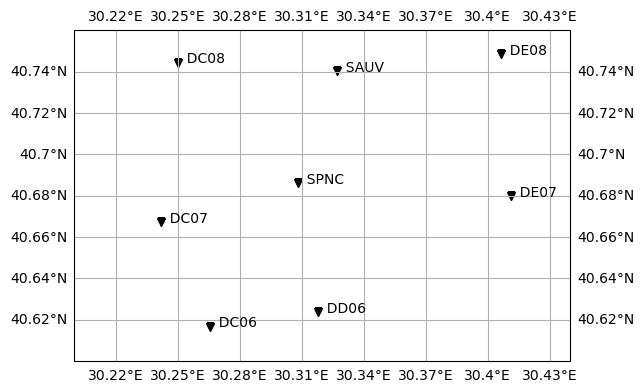

In [7]:
MAP_EXTENT = (
    domain.minlongitude,
    domain.maxlongitude,
    domain.minlatitude,
    domain.maxlatitude,
)

# Read inventory
inventory = read_inventory(os.path.join(DIRPATH_DESTINATION, "*.xml"))

# Create axes
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent(MAP_EXTENT)
ax.gridlines(draw_labels=True)
ax.coastlines()

# Show
for network in inventory:
    for station in network:
        ax.plot(station.longitude, station.latitude, "kv")
        ax.text(station.longitude, station.latitude, "  " + station.code)
